In [1]:
import json
import sys
import tempfile
from urllib.parse import urljoin

import requests
import xgboost as xgb
from opensearchpy import OpenSearch
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_tree

In [2]:
host = 'localhost'
port = 9200
base_url = "https://{}:{}/".format(host, port)
auth = ('admin', 'admin')  # For testing only. Don't store credentials in code.

In [3]:
client = OpenSearch(
    hosts=[{'host': host, 'port': port}],
    http_compress=True,  # enables gzip compression for request bodies
    http_auth=auth,
    # client_cert = client_cert_path,
    # client_key = client_key_path,
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False,
)

In [4]:
docs = [
    {
        "id": "doc_a",
        "title": "Fox and Hounds",
        "body": "The quick red fox jumped over the lazy brown dogs.",
        "price": "5.99",
        "in_stock": True,
        "category": "childrens"},
    {
        "id": "doc_b",
        "title": "Fox wins championship",
        "body": "Wearing all red, the Fox jumped out to a lead in the race over the Dog.",
        "price": "15.13",
        "in_stock": True,
        "category": "sports"},
    {
        "id": "doc_c",
        "title": "Lead Paint Removal",
        "body": "All lead must be removed from the brown and red paint.",
        "price": "150.21",
        "in_stock": False,
        "category": "instructional"},
    {
        "id": "doc_d",
        "title": "The Three Little Pigs Revisited",
        "price": "3.51",
        "in_stock": True,
        "body": "The big, bad wolf huffed and puffed and blew the house down. The end.",
        "category": "childrens"},
    {
        "id": "doc_e",
        "title": "Pigs in a Blanket and Other Recipes",
        "price": "27.50",
        "in_stock": True,
        "body": "Pigs in a blanket aren't as cute as you would think given it's a food and not actual pigs wrapped in blankets.",
        "category": "instructional"},
    {
        "id": "doc_f",
        "title": "Dogs are the best",
        "body": "Dogs beat cats every day of the week and twice on Sunday. A dog is always up for doing something.  Since there are so many dog breeds, there is a dog for everyone!",
        "price": "50.99",
        "in_stock": True,
        "category": "childrens"},
    {
        "id": "doc_g",
        "title": "Dog",
        "body": "Dogs rule",
        "price": "5.99",
        "in_stock": True,
        "category": "childrens"},
    {
        "id": "doc_h",
        "title": "Dog: The bounty hunter: living in the red",
        "body": "Dog is a bounty hunter who goes on pretend missions with his friends, one of whom is the Fox",
        "price": "125.99",
        "in_stock": True,
        "category": "sports"},
]

In [5]:
index_name = 'searchml_ltr'
index_body = {
    'settings': {
        'index': {
            'query': {
                'default_field': "body"
            }
        }
    },
    "mappings": {
        "properties": {
            "title": {"type": "text", "analyzer": "english"},
            "body": {"type": "text", "analyzer": "english"},
            "in_stock": {"type": "boolean"},
            "category": {"type": "keyword", "ignore_above": "256"},
            "price": {"type": "float"}
        }
    }
}


In [6]:
client.indices.delete(index_name, ignore_unavailable=True)
client.indices.create(index_name, body=index_body)


{'acknowledged': True, 'shards_acknowledged': True, 'index': 'searchml_ltr'}

In [7]:
print("Indexing our documents")
for doc in docs:
    doc_id = doc["id"]
    print("\tIndexing {}".format(doc_id))
    client.index(
        index=index_name,
        body=doc,
        id=doc_id,
        refresh=True
    )


Indexing our documents
	Indexing doc_a
	Indexing doc_b
	Indexing doc_c
	Indexing doc_d
	Indexing doc_e
	Indexing doc_f
	Indexing doc_g
	Indexing doc_h


In [8]:
print("We indexed:\n{}".format(client.cat.count(index_name, params={"v": "true"})))


We indexed:
epoch      timestamp count
1655909722 14:55:22  8



In [9]:
ltr_store_name = index_name
ltr_store_path = "_ltr/" + ltr_store_name

print("Create our LTR store")
# LTR requests are not supported by the OpenSearchPy client, so we will drop down to using Python's Requests library
ltr_model_path = urljoin(base_url, ltr_store_path)
# Delete any old storage
resp = requests.delete(ltr_model_path, auth=auth, verify=False)
print("\tDeleted old store response status: %s" % resp.status_code)
# Create our new LTR storage
resp = requests.put(ltr_model_path, auth=auth, verify=False)
print("\tCreate the new store response status: %s" % resp.status_code)


Create our LTR store
	Deleted old store response status: 200
	Create the new store response status: 200


In [10]:
featureset_name = "ltr_toy"
headers = {"Content-Type": 'application/json'}
featureset_path = urljoin(ltr_model_path + "/", "_featureset/{}".format(featureset_name))
print("featureset_path:", featureset_path)
# Upload our feature set to our model
body_query_feature_name = "body_query"
title_query_feature_name = "title_query"
price_func_feature_name = "price_func"


featureset_path: https://localhost:9200/_ltr/searchml_ltr/_featureset/ltr_toy


In [11]:
print("\tUpload our features to the LTR storage")
ltr_feature_set = {"featureset": {
    "features": [
        {  # Instead of using our multifield query_string match, break it out into parts
            "name": title_query_feature_name,
            "params": ["keywords"],
            "template_language": "mustache",
            "template": {
                "match": {
                    "title": "{{keywords}}"
                }
            }
        },
        {  # Instead of using our multifield query_string match, break it out into parts
            "name": body_query_feature_name,
            "params": ["keywords"],
            "template_language": "mustache",
            "template": {
                "match": {
                    "body": "{{keywords}}"
                }
            }
        },
        # factor in price, albeit naively for this purpose, in practice we should normalize it, which we will do in the project!
        {
            "name": ("%s" % price_func_feature_name),
            "template_language": "mustache",
            "template": {
                "function_score": {
                    "functions": [{
                        "field_value_factor": {
                            "field": "price",
                            "missing": 0
                        }
                    }],
                    "query": {
                        "match_all": {}
                    }
                }
            }

        }
    ]
}}
resp = requests.post(featureset_path, headers=headers, data=json.dumps(ltr_feature_set), auth=auth, verify=False)



	Upload our features to the LTR storage


In [12]:
class Judgment:

    def __init__(self, query, doc_id, display_name, grade=0, features=[], query_str=None):
        self.query = query
        self.query_str = query_str
        self.doc_id = doc_id
        self.display_name = display_name
        self.grade = grade
        self.features = features

    # Modified from https://github.com/o19s/elasticsearch-ltr-demo/blob/master/train/judgments.py
    def toXGBFormat(self):
        featuresAsStrs = ["%s:%s" % (idx + 1, feature.get('value', 0)) for idx, feature in enumerate(self.features)]
        comment = "# %s\t%s" % (self.doc_id, self.query_str)
        return "%s\tqid:%s\t%s %s" % (self.grade, self.query, "\t".join(featuresAsStrs), comment)



In [13]:
queries = {1: "dogs", 2: "red fox", 3: "wolf huffed AND puffed OR pig"}
judgments = {}

In [14]:
answers = [1, 1, 1, 1, 1, 1, 1, 1, 0, 1]
# Loop over queries, execute a search
for query in queries:
    # Used to get the original queries to create the judgments
    query_obj = {
        'size': 5,
        'query': {
            'multi_match': {
                'query': queries[query],
                'fields': ['title^2', 'body']
            }
        }
    }
    print("################\nExecuting search: qid: {}; query: {}\n##########".format(query, queries[query]))
    response = client.search(body=query_obj, index=index_name)
    hits = response['hits']['hits']
    if len(hits) > 0:
        print(
            "For each hit answer the question: 'Is this hit relevant(1) or not relevant(0) to the query: {}?':".format(
                queries[query]))
        judge_vals = judgments.get(query)
        if judge_vals is None:
            judge_vals = []
            judgments[query] = judge_vals
        for hit in hits:
            print("Title: {}\n\nBody: {}\n".format(hit['_source']['title'], hit['_source']['body']))
            print("Enter 0 or 1:")
            i = ""
            for i in input("input:"):
                grade = i.rstrip()
                if grade == "0" or grade == "1":
                    judgment = Judgment(query, hit['_id'], hit['_source']['title'], int(grade))
                    judge_vals.append(judgment)
                    break
                elif grade == "skip" or grade == "s":
                    break
                elif grade == "exit" or grade == 'e':
                    i = grade  # set this back to the trimmed grade so we can exit the outer loop.  Very clunky!
                    break
            if i == "exit" or i == "e":
                break  # break out of hits, this is ugly, but OK for what we are doing here

################
Executing search: qid: 1; query: dogs
##########
For each hit answer the question: 'Is this hit relevant(1) or not relevant(0) to the query: dogs?':
Title: Dog

Body: Dogs rule

Enter 0 or 1:
input:1
Title: Dogs are the best

Body: Dogs beat cats every day of the week and twice on Sunday. A dog is always up for doing something.  Since there are so many dog breeds, there is a dog for everyone!

Enter 0 or 1:
input:1
Title: Dog: The bounty hunter: living in the red

Body: Dog is a bounty hunter who goes on pretend missions with his friends, one of whom is the Fox

Enter 0 or 1:
input:1
Title: Fox and Hounds

Body: The quick red fox jumped over the lazy brown dogs.

Enter 0 or 1:
input:1
Title: Fox wins championship

Body: Wearing all red, the Fox jumped out to a lead in the race over the Dog.

Enter 0 or 1:
input:1
################
Executing search: qid: 2; query: red fox
##########
For each hit answer the question: 'Is this hit relevant(1) or not relevant(0) to the quer

In [15]:
judgments

{1: [<__main__.Judgment at 0x7f668ede65b0>,
 2: [<__main__.Judgment at 0x7f6665ab6cd0>,
 3: [<__main__.Judgment at 0x7f6665a971f0>,
  <__main__.Judgment at 0x7f65fb1a5f10>]}

In [16]:
train_file = tempfile.NamedTemporaryFile(delete=False)
# Log our features by sending our query and it's judged documents to OpenSearch
for (idx, item) in enumerate(judgments.items()):
    judge_vals = item[1]
    # create a new SLTR query with an appropriate filter query
    doc_ids = []
    for judgment in judge_vals:
        # Note: we are executing one query per judgment doc id here because it's easier, but we could do this
        # by adding all the doc ids for this query and scoring them all at once and cut our number of queries down
        # significantly
        # Create our SLTR query, filtering so we only retrieve the doc id in question
        query_obj = {
            'query': {
                'bool': {
                    "filter": [  # use a filter so that we don't actually score anything
                        {
                            "terms": {
                                "_id": [judgment.doc_id]
                            }
                        },
                        {  # use the LTR query bring in the LTR feature set
                            "sltr": {
                                "_name": "logged_featureset",
                                "featureset": featureset_name,
                                "store": ltr_store_name,
                                "params": {
                                    "keywords": queries[judgment.query]
                                }
                            }
                        }
                    ]
                }
            },
            # Turn on feature logging so that we get weights back for our features
            "ext": {
                "ltr_log": {
                    "log_specs": {
                        "name": "log_entry",
                        "named_query": "logged_featureset"
                    }
                }
            }
        }
        # Run the query just like any other search
        response = client.search(body=query_obj, index=index_name)
        print(response)
        # For each response, extract out the features and build our training features
        # We are going to do this by iterating through the hits, which should be in doc_ids order and put the
        # values back onto the Judgment object, which has a place to store these.
        if response and len(response['hits']) > 0 and len(response['hits']['hits']) == 1:
            hits = response['hits']['hits']
            # there should only be one hit
            judgment.features = hits[0]['fields']['_ltrlog'][0]['log_entry']
            # 		<grade> qid:<query_id> <feature_number>:<weight>... # <doc_id> <comments>
            # see https://xgboost.readthedocs.io/en/latest/tutorials/input_format.html
            xgb_format = judgment.toXGBFormat() + "\n"
            print(xgb_format)
            train_file.write(bytes(xgb_format, 'utf-8'))
        else:
            print("Weirdness. Fix")

train_file.close()



{'took': 43, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 0.0, 'hits': [{'_index': 'searchml_ltr', '_type': '_doc', '_id': 'doc_g', '_score': 0.0, '_source': {'id': 'doc_g', 'title': 'Dog', 'body': 'Dogs rule', 'price': '5.99', 'in_stock': True, 'category': 'childrens'}, 'fields': {'_ltrlog': [{'log_entry': [{'name': 'title_query', 'value': 1.2986346}, {'name': 'body_query', 'value': 0.7342377}, {'name': 'price_func', 'value': 5.99}]}]}, 'matched_queries': ['logged_featureset']}]}}
1	qid:1	1:1.2986346	2:0.7342377	3:5.99 # doc_g	None

{'took': 6, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 0.0, 'hits': [{'_index': 'searchml_ltr', '_type': '_doc', '_id': 'doc_f', '_score': 0.0, '_source': {'id': 'doc_f', 'title': 'Dogs are the best', 'body': 'Dogs beat cats every day of the we

In [19]:
train_file.name

'/tmp/tmph207f2v6'

In [20]:
!cat /tmp/tmph207f2v6

1	qid:1	1:1.2986346	2:0.7342377	3:5.99 # doc_g	None
1	qid:1	1:1.0935872	2:0.7156082	3:50.99 # doc_f	None
1	qid:1	1:0.742077	2:0.46032518	3:125.99 # doc_h	None
1	qid:1	1:0	2:0.5410643	3:5.99 # doc_a	None
1	qid:1	1:0	2:0.49743986	3:15.13 # doc_b	None
1	qid:2	1:1.4831866	2:2.0752847	3:5.99 # doc_a	None
1	qid:2	1:1.4078112	2:0.8828025	3:125.99 # doc_h	None
1	qid:2	1:1.2809337	2:1.9079604	3:15.13 # doc_b	None
0	qid:2	1:0	2:1.0376424	3:150.21 # doc_c	None
1	qid:3	1:1.1272218	2:5.657528	3:3.51 # doc_d	None
0	qid:3	1:1.1272218	2:2.2908108	3:27.5 # doc_e	None


In [28]:
from pprint import pprint


In [32]:
[pprint(vars(j)) for j in judgments[2]]

{'display_name': 'Fox and Hounds',
 'doc_id': 'doc_a',
 'features': [{'name': 'title_query', 'value': 1.4831866},
              {'name': 'body_query', 'value': 2.0752847},
              {'name': 'price_func', 'value': 5.99}],
 'grade': 1,
 'query': 2,
 'query_str': None}
{'display_name': 'Dog: The bounty hunter: living in the red',
 'doc_id': 'doc_h',
 'features': [{'name': 'title_query', 'value': 1.4078112},
              {'name': 'body_query', 'value': 0.8828025},
              {'name': 'price_func', 'value': 125.99}],
 'grade': 1,
 'query': 2,
 'query_str': None}
{'display_name': 'Fox wins championship',
 'doc_id': 'doc_b',
 'features': [{'name': 'title_query', 'value': 1.2809337},
              {'name': 'body_query', 'value': 1.9079604},
              {'name': 'price_func', 'value': 15.13}],
 'grade': 1,
 'query': 2,
 'query_str': None}
{'display_name': 'Lead Paint Removal',
 'doc_id': 'doc_c',
 'features': [{'name': 'title_query'},
              {'name': 'body_query', 'value': 1.0

[None, None, None, None]

In [33]:
feat_map_file = tempfile.NamedTemporaryFile(delete=False)
feat_map_file.write(bytes("0\tna\tq\n", "utf-8"))
feat_map_file.write(bytes('1\t{}\tq\n'.format(title_query_feature_name), 'utf-8'))
feat_map_file.write(bytes('2\t{}\tq\n'.format(body_query_feature_name), 'utf-8'))
feat_map_file.write(bytes('3\t{}\tq\n'.format(price_func_feature_name), 'utf-8'))
feat_map_file.close()

In [35]:
!cat /tmp/tmpysuvv0ts

0	na	q
1	title_query	q
2	body_query	q
3	price_func	q


In [36]:
dtrain = xgb.DMatrix(train_file.name)
param = {'max_depth': 5,  'silent': 1, 'objective': 'reg:linear'}
num_round = 5
print("Training XG Boost")
bst = xgb.train(param, dtrain,
                num_round)  # Do the training.  NOTE: in this toy example we did not use any hold out data
model = bst.get_dump(fmap=feat_map_file.name, dump_format='json')

Training XG Boost
[15:05:07] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:07] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [37]:
# We need to escape entries for uploading to OpenSearch, per the docs
model_str = '[' + ','.join(list(model)) + ']'
print(model_str)

[  { "nodeid": 0, "depth": 0, "split": "price_func", "split_condition": 138.100006, "yes": 1, "no": 2, "missing": 1 , "children": [
    { "nodeid": 1, "depth": 1, "split": "body_query", "split_condition": 2.18304777, "yes": 3, "no": 4, "missing": 3 , "children": [
      { "nodeid": 3, "leaf": 0.13333334 }, 
      { "nodeid": 4, "depth": 2, "split": "body_query", "split_condition": 3.97416925, "yes": 5, "no": 6, "missing": 5 , "children": [
        { "nodeid": 5, "leaf": -0.075000003 }, 
        { "nodeid": 6, "leaf": 0.075000003 }
      ]}
    ]}, 
    { "nodeid": 2, "leaf": -0.075000003 }
  ]},  { "nodeid": 0, "depth": 0, "split": "price_func", "split_condition": 138.100006, "yes": 1, "no": 2, "missing": 1 , "children": [
    { "nodeid": 1, "depth": 1, "split": "body_query", "split_condition": 2.18304777, "yes": 3, "no": 4, "missing": 3 , "children": [
      { "nodeid": 3, "leaf": 0.0977777913 }, 
      { "nodeid": 4, "depth": 2, "split": "body_query", "split_condition": 3.97416925, "

In [38]:
# Create our metadata for uploading the model
model_name = "ltr_toy_model"

os_model = {
    "model": {
        "name": model_name,
        "model": {
            "type": "model/xgboost+json",
            "definition": '{"objective":"reg:linear", "splits":' + model_str + '}'
        }
    }
}

In [40]:
model_path = urljoin(featureset_path + "/", "_createmodel")
print("Uploading our model to %s" % model_path)
response = requests.post(model_path, data=json.dumps(os_model), headers=headers, auth=auth, verify=False)
print("\tResponse: %s" % response)

Uploading our model to https://localhost:9200/_ltr/searchml_ltr/_featureset/ltr_toy/_createmodel
	Response: <Response [201]>


In [41]:
print("Search with baseline")
query_obj = {
    'query': {
        'multi_match': {
            'query': queries[1],
            'fields': ['title^2', 'body']
        }
    },
}
response = client.search(body=query_obj, index=index_name)
print("Response:\n%s" % json.dumps(response, indent=True))

Search with baseline
Response:
{
 "took": 3,
 "timed_out": false,
 "_shards": {
  "total": 1,
  "successful": 1,
  "skipped": 0,
  "failed": 0
 },
 "hits": {
  "total": {
   "value": 5,
   "relation": "eq"
  },
  "max_score": 2.5972693,
  "hits": [
   {
    "_index": "searchml_ltr",
    "_type": "_doc",
    "_id": "doc_g",
    "_score": 2.5972693,
    "_source": {
     "id": "doc_g",
     "title": "Dog",
     "body": "Dogs rule",
     "price": "5.99",
     "in_stock": true,
     "category": "childrens"
    }
   },
   {
    "_index": "searchml_ltr",
    "_type": "_doc",
    "_id": "doc_f",
    "_score": 2.1871743,
    "_source": {
     "id": "doc_f",
     "title": "Dogs are the best",
     "body": "Dogs beat cats every day of the week and twice on Sunday. A dog is always up for doing something.  Since there are so many dog breeds, there is a dog for everyone!",
     "price": "50.99",
     "in_stock": true,
     "category": "childrens"
    }
   },
   {
    "_index": "searchml_ltr",
    "

In [42]:
print("Search with LTR")

query_obj["rescore"] = {
    "window_size": 10,
    "query": {
        "rescore_query": {
            "sltr": {
                "params": {
                    "keywords": queries[1]
                },
                "model": model_name,
                # Since we are using a named store, as opposed to simply '_ltr', we need to pass it in
                "store": ltr_store_name,
                "active_features": [title_query_feature_name, body_query_feature_name, price_func_feature_name]
            }
        },
        "rescore_query_weight": "2" # Magic number, but let's say LTR matches are 2x baseline matches
    }
}
response = client.search(body=query_obj, index=index_name)
print("Response:\n%s" % json.dumps(response, indent=True))

Search with LTR
Response:
{
 "took": 12,
 "timed_out": false,
 "_shards": {
  "total": 1,
  "successful": 1,
  "skipped": 0,
  "failed": 0
 },
 "hits": {
  "total": {
   "value": 5,
   "relation": "eq"
  },
  "max_score": 3.3851857,
  "hits": [
   {
    "_index": "searchml_ltr",
    "_type": "_doc",
    "_id": "doc_g",
    "_score": 3.3851857,
    "_source": {
     "id": "doc_g",
     "title": "Dog",
     "body": "Dogs rule",
     "price": "5.99",
     "in_stock": true,
     "category": "childrens"
    }
   },
   {
    "_index": "searchml_ltr",
    "_type": "_doc",
    "_id": "doc_f",
    "_score": 2.9750907,
    "_source": {
     "id": "doc_f",
     "title": "Dogs are the best",
     "body": "Dogs beat cats every day of the week and twice on Sunday. A dog is always up for doing something.  Since there are so many dog breeds, there is a dog for everyone!",
     "price": "50.99",
     "in_stock": true,
     "category": "childrens"
    }
   },
   {
    "_index": "searchml_ltr",
    "_typ

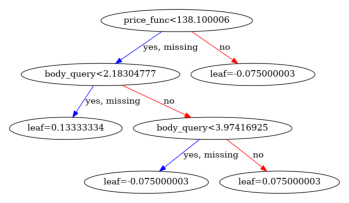

In [43]:
model_plot = plot_tree(bst, feat_map_file.name)
model_plot.figure.savefig("ltr_toy_model.png")

plt.show()